# import

In [1]:
# !pip install pycaret
# !pip install shap

In [2]:
import os, sys, random
import numpy as np
import pandas as pd

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

# 評価算出
from sklearn.metrics import f1_score

# from google.colab import drive
# from google.colab import files
# import os
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/SIGNATE/楽曲ジャンル推定/')
# os.getcwd()

datapath = "Data/"
savepath="Model/Model_002/"
submitcsv = 'Submit/submit_003.csv'

# データ読み込み

In [3]:
#　読み込み
df_train = pd.read_csv(datapath+"train.csv")
df_test = pd.read_csv(datapath+"test.csv")
display(df_train)

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,4041,10,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,121-152,region_P
4042,4042,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,121-152,region_D
4043,4043,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,97-120,region_E
4044,4044,10,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,77-96,region_R


# ジャンル8,10を半減

In [4]:
def cut_genre_len(df, genre_nun):
  df_ind = df[df['genre']==genre_nun].sample(frac=1, random_state=0).index
  df_ind = df_ind[:int(len(df_ind)/2)]
  df.drop(df.index[df_ind], inplace=True)
  df.reset_index(inplace=True, drop=True)
  return df

In [5]:
cut_genre_len(df_train, 8)
cut_genre_len(df_train, 10)

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown
4,6,10,31,218589,0.254065,0.794563,0.489803,-1.681586,0.703885,0.130464,0.217456,0.128179,77-96,region_N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,4038,7,50,287682,0.766699,0.019794,0.267809,-13.435984,0.247339,0.239206,0.137388,0.155591,97-120,region_B
2722,4040,10,17,219123,0.092855,0.144303,0.298678,-4.833738,0.821060,0.452820,0.156497,0.272721,177-192,region_E
2723,4042,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,121-152,region_D
2724,4043,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,97-120,region_E


In [6]:
len(df_train) # 2726

2726

# Pycaret

In [25]:
from pycaret.classification import *

# 
exp1 = setup(df_train, target = 'genre', session_id=32, ignore_features=['index'])
# X, y, X_train, X_test, y_train, y_test, seed, prep_pipe, experiment__ \
# = setup(df_train, target = 'genre', session_id=32, ignore_features=['index'])
print(type(exp1))
exp1

,Description,Value
0,session_id,32
1,Target,genre
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 10: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10"
4,Original Data,"(2726, 14)"
5,Missing Values,True
6,Numeric Features,10
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


<class 'tuple'>


(5,
 [],
 'genre',
 False,
 True,
 'box-cox',
 -1,
       popularity  duration_ms  acousticness  positiveness  danceability  \
 1034        45.0     134095.0      0.164303      0.487724      0.475246   
 1398        35.0      98077.0      0.270763      0.464025      0.772199   
 1563        37.0     155988.0      0.135729      0.747136      0.749967   
 1241        28.0     148055.0      0.667577      0.795720      0.523557   
 448         15.0     194480.0      0.774322      0.451617      0.610355   
 ...          ...          ...           ...           ...           ...   
 510         40.0     242001.0      0.224169      0.368084      0.376578   
 252         16.0     199002.0      0.217517      0.893389      0.600509   
 2136        41.0     323723.0      0.296769      0.781347      0.716228   
 1334        57.0     256391.0      0.798104      0.211307      0.408095   
 1579        49.0     265159.0      0.184087      0.123711      0.667000   
 
        loudness    energy  livenes

In [8]:
# モデルの比較
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5964,0.8842,0.5129,0.5961,0.5831,0.5065,0.5093,0.1190
gbc,Gradient Boosting Classifier,0.5886,0.8744,0.5026,0.5867,0.5745,0.4971,0.5002,0.7400
lightgbm,Light Gradient Boosting Machine,0.5818,0.8683,0.4658,0.5827,0.5633,0.4845,0.4887,0.1980
rf,Random Forest Classifier,0.5640,0.8683,0.4454,0.5726,0.5384,0.4597,0.4653,0.1310
lda,Linear Discriminant Analysis,0.5220,0.8304,0.4718,0.5191,0.5132,0.4230,0.4252,0.0090
ridge,Ridge Classifier,0.5089,0.0000,0.3303,0.4588,0.4666,0.3876,0.3936,0.0070
dt,Decision Tree Classifier,0.4376,0.6635,0.3785,0.4407,0.4351,0.3260,0.3268,0.0070
nb,Naive Bayes,0.3506,0.6832,0.1665,0.2544,0.2682,0.1544,0.1829,0.0060
ada,Ada Boost Classifier,0.3076,0.5576,0.2111,0.2712,0.2298,0.1256,0.1594,0.0340
lr,Logistic Regression,0.2442,0.5095,0.0909,0.0597,0.0959,0.0000,0.0000,0.1580


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=32, verbose=0,
                     warm_start=False)

# LightGBM単体

In [9]:
# 引数で使用するモデルを指定する
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5654,0.8734,0.4138,0.5629,0.5439,0.4631,0.4702
1,0.5654,0.8480,0.4427,0.5719,0.5461,0.4653,0.4690
2,0.5864,0.8824,0.4276,0.5698,0.5646,0.4898,0.4943
3,0.6073,0.8822,0.4726,0.5904,0.5875,0.5192,0.5215
4,0.5183,0.8381,0.4701,0.5344,0.4975,0.4029,0.4084
5,0.6597,0.8939,0.5096,0.6412,0.6347,0.5817,0.5856
6,0.5759,0.8626,0.5455,0.5802,0.5549,0.4743,0.4801
7,0.5340,0.8594,0.3788,0.5090,0.5172,0.4294,0.4308
8,0.6368,0.8850,0.5313,0.6578,0.6295,0.5540,0.5577
9,0.5684,0.8581,0.4656,0.6092,0.5575,0.4650,0.4698


In [10]:
# チューニング　　第二引数：ランダムグリッドサーチの回数
tuned_lgbm = tune_model(lgbm, n_iter = 50, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5602,0.8561,0.4956,0.5567,0.5441,0.4588,0.4632
1,0.6126,0.8298,0.5510,0.6003,0.5843,0.5233,0.5277
2,0.6283,0.8939,0.5132,0.6104,0.6006,0.5407,0.5466
3,0.6126,0.8570,0.5493,0.6181,0.6024,0.5272,0.5299
4,0.5183,0.8482,0.4916,0.5366,0.5013,0.4052,0.4087
5,0.5969,0.8665,0.4702,0.5570,0.5679,0.5029,0.5080
6,0.5131,0.8393,0.4868,0.5013,0.4871,0.3982,0.4032
7,0.5445,0.8527,0.4316,0.5457,0.5191,0.4366,0.4417
8,0.6105,0.8843,0.4804,0.6267,0.6031,0.5187,0.5243
9,0.5368,0.8415,0.4554,0.5683,0.5286,0.4296,0.4324


In [11]:
# 解析結果の確認
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# エンコーディング

In [47]:
# ラベルエンコーディング（LabelEncoder）
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
encoded1 = le1.fit_transform(df_train['region'].values)
# decoded1 = le1.inverse_transform(encoded1)
df_train['region'] = encoded1

le2 = LabelEncoder()
encoded2 = le2.fit_transform(df_train['tempo'].values)
# decoded2 = le1.inverse_transform(encoded2)
df_train['tempo'] = encoded2

# tSNE

38066
38066


,index,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,0,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,1,7
1,1,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,2,8
2,2,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,8,4
3,4,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,10,20
4,6,31,218589,0.254065,0.794563,0.489803,-1.681586,0.703885,0.130464,0.217456,0.128179,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,4038,50,287682,0.766699,0.019794,0.267809,-13.435984,0.247339,0.239206,0.137388,0.155591,10,1
2722,4040,17,219123,0.092855,0.144303,0.298678,-4.833738,0.821060,0.452820,0.156497,0.272721,3,4
2723,4042,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,1,3
2724,4043,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,10,4


0       10
1        8
2        3
3        3
4       10
        ..
2721     7
2722    10
2723     5
2724    10
2725     3
Name: genre, Length: 2719, dtype: int64

[[-1.74065111 -1.93076039 -0.50712578 ...  4.69604881 -1.12203121
  -0.40630229]
 [-1.73978969  1.72649473  0.84049469 ... -0.57926693 -0.87808408
  -0.23863862]
 [-1.73892826  0.08703554 -0.5556732  ... -0.28577338  0.58559873
  -0.90929331]
 ...
 [ 1.74123216 -1.17408691 -0.41126064 ...  0.60477047 -1.12203121
  -1.07695698]
 [ 1.74209358 -0.73269406  2.07674094 ... -0.30637178  1.073493
  -0.90929331]
 [ 1.74381643 -0.22824508 -0.70245728 ... -0.34152249  1.073493
  -0.90929331]]
[10  8  3 ...  5 10  3]


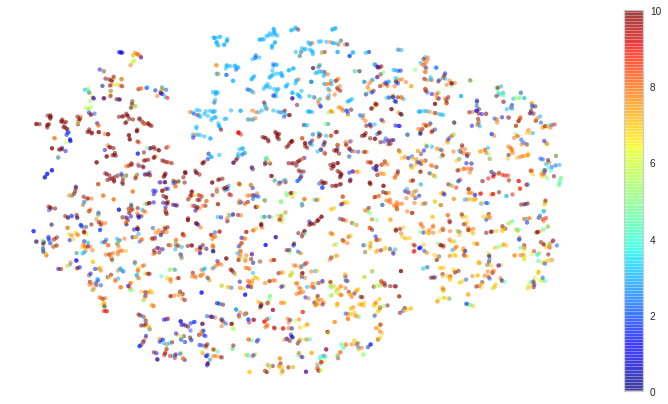

In [60]:
from sklearn.manifold import TSNE

# 欠損を削除
print(df_train.size)
df_train = df_train.dropna()
print(df_train.size)

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

df_norm = mean_norm(df_train)

X, y = df_train.drop("genre", axis=1), df_train["genre"]

# X, y = get_config('X'), get_config("y")
display(X)
display(y)

X = mean_norm(X)

X, y = X.values, y.values

print(X)
print(y)

tsne = TSNE(n_components=2, random_state=41, perplexity=5)
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y, cmap='jet',
            s=15, alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

In [61]:
df_train.isna().sum()

index               0
genre               0
popularity          0
duration_ms         0
acousticness        0
positiveness        0
danceability        0
loudness            0
energy              0
liveness            0
speechiness         0
instrumentalness    0
tempo               0
region              0
dtype: int64

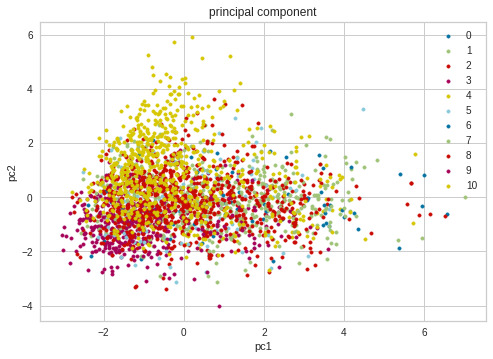

In [63]:
from sklearn.decomposition import PCA

# 主成分分析する
pca = PCA(n_components=2)
pca.fit(X)

# 分析結果を元にデータセットを主成分に変換する
transformed = pca.fit_transform(X)

# 主成分をプロットする
for label in np.unique(y):
    
#     if label in [8, 10]:
#         continue
    
    plt.scatter(transformed[y == label, 0],
        transformed[y == label, 1], label=str(label), marker=".")
    plt.title('principal component')
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    
plt.legend()

In [66]:
!pip install pyarrow

import pyarrow as pa

     |████████████████████████████████| 20.7 MB 3.2 MB/s eta 0:00:01


In [68]:
features_path = "Data/Dataset_004/"
train_f = pd.read_parquet(features_path+"train.parq")

display(train_f)

,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,...,popularity - positiveness,popularity - region,popularity - speechiness,popularity - tempo,positiveness - region,positiveness - speechiness,positiveness - tempo,region - speechiness,region - tempo,speechiness - tempo
0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,...,10.842753,10,10.609892,10,-0.842753,-0.232861,-0.842753,0.609892,0,-0.609892
1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,...,68.653437,67,68.838503,67,-1.653437,0.185066,-1.653437,1.838503,0,-1.838503
2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,...,42.734609,40,42.630943,40,-2.734609,-0.103666,-2.734609,2.630943,0,-2.630943
3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,...,44.754467,41,44.773323,41,-3.754467,0.018856,-3.754467,3.773323,0,-3.773323
4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,...,56.222422,52,56.777512,52,-4.222422,0.555090,-4.222422,4.777512,0,-4.777512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,10,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,...,37.670282,27,37.812669,37,-10.670282,0.142388,-0.670282,10.812669,10,-0.812669
4032,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,...,22.771243,9,22.858782,22,-13.771243,0.087538,-0.771243,13.858782,13,-0.858782
4033,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,...,29.537626,27,29.847730,25,-2.537626,0.310104,-4.537626,2.847730,-2,-4.847730
4034,10,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,...,24.534489,13,24.797762,19,-11.534489,0.263273,-5.534489,11.797762,6,-5.797762


# SHAP

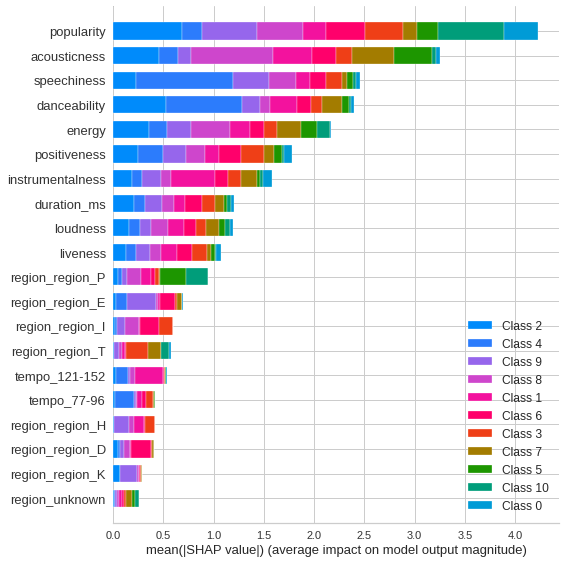

In [12]:
# SHAP
interpret_model(tuned_lgbm)

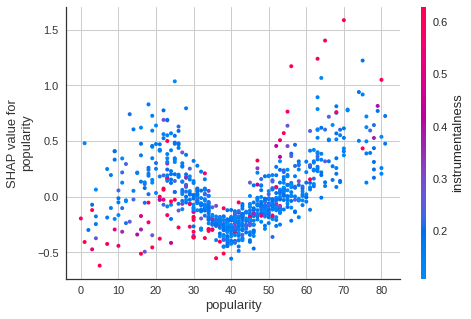

In [13]:
interpret_model(tuned_lgbm, plot='correlation', observation=320)

# Cross Validation

In [14]:
# Validation
# チューニングしたモデルを使用
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5905,0.8783,0.4955,0.6073,0.5745,0.4977,0.5025


,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,...,region_region_O,region_region_P,region_region_Q,region_region_R,region_region_S,region_region_T,region_unknown,genre,Label,Score
0,34.0,226733.0,0.162529,0.884212,0.876988,-2.244080,0.845952,0.364012,0.187594,0.136672,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,3,0.8964
1,38.0,228643.0,0.665135,0.319327,0.447399,-11.335747,0.235423,0.212940,0.173219,0.212879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7,0.9284
2,23.0,355906.0,0.299204,0.632217,0.649004,-9.709639,0.702872,0.164713,0.121118,0.143526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,10,0.6223
3,31.0,245334.0,0.136184,0.961540,0.569699,-8.308741,0.778949,0.339835,0.201133,0.175924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,0.9330
4,58.0,237265.0,0.183920,0.594438,0.699282,-5.338752,0.702666,0.188504,0.476053,0.149491,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,3,0.9948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,46.0,220718.0,0.672170,0.158348,0.377849,-13.535919,0.391382,0.286596,0.119475,0.156124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,7,0.8195
814,38.0,274851.0,0.217275,0.341443,0.628920,-9.319245,0.408815,0.427335,0.173016,0.130647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,5,0.5835
815,50.0,268829.0,0.279631,0.255600,0.604752,-9.707902,0.406646,0.180871,0.118787,0.198835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,0.7137
816,48.0,287891.0,0.839801,0.084519,0.293296,-21.213753,0.154411,0.670175,0.189744,0.181842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7,0.8194


# Test

In [15]:
# テストデータの予測
final_lgbm = finalize_model(tuned_lgbm)
test_predictions = predict_model(final_lgbm, data=df_test)
test_predictions

,index,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region,Label,Score
0,4046,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,0.214989,0.161924,77-96,region_I,8,0.7404
1,4047,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,0.184183,0.155460,121-152,unknown,10,0.9639
2,4048,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,0.167352,0.179191,121-152,region_K,8,0.7610
3,4049,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,0.174403,0.186061,77-96,region_D,8,0.7964
4,4050,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,0.157594,0.184142,97-120,region_E,8,0.9619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,8087,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,121-152,region_B,10,0.9796
4042,8088,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,121-152,region_I,8,0.9138
4043,8089,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,121-152,region_H,1,0.3357
4044,8090,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,121-152,region_B,8,0.8711


In [16]:
# モデルの保存
os.mkdir(savepath)
save_model(final_lgbm, savepath+'LightGBM')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['index'], id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='genre',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.9,
                                 importance_type='split', learning_rate=0.1,
                                 max_depth=-1,

# 提出ファイル作成

In [17]:
submit = test_predictions[['index', 'Label']]
submit

,index,Label
0,4046,8
1,4047,10
2,4048,8
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [21]:
submit.to_csv(submitcsv, header=None,index=False)

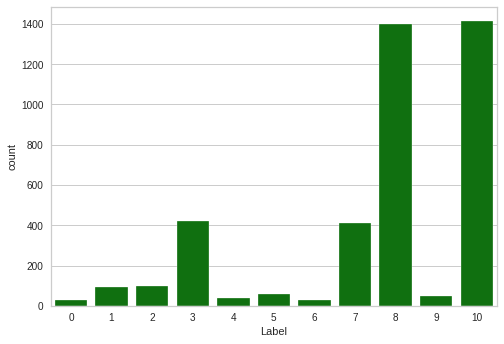

In [19]:
# テストデータ予測結果確認
sns.countplot(x="Label", data=submit, color='green')